Import Libraries

In [ ]:
import h5py
import pandas as pd
import sklearn
import sklearn.model_selection
import torch
import torch.nn.functional as F
from torch.nn.functional import one_hot
import torch.nn as nn
from google.colab import files
import io
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

Import Physics Sample Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Process Sample Data

In [ ]:
file = h5py.File("/content/drive/MyDrive/Colab_Notebooks/Data_Fuchs_v_0_lambda_um_0.8_points_100000_seed_0.h5",'r')
file_dict = dict()

for i in file.keys():
    file_dict[i] = file[i][:]
file.close()

physics = pd.DataFrame(file_dict)
# physics.info()

Splitting the data for training and testing.

In [ ]:
physics_norm = physics.copy()
total_count = len(physics)
# print(physics)
# print(total_count)

for column in physics_norm:
    physics_norm[column] = (physics_norm[column] - physics_norm[column].mean())/physics_norm[column].std()

physics_train_norm, physics_test_norm = sklearn.model_selection.train_test_split(physics_norm, train_size=0.8, random_state=1)

print(physics.head())
print(physics_norm.head())

Plot the data for better context

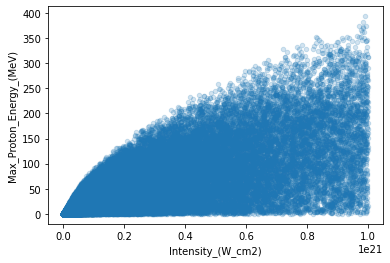

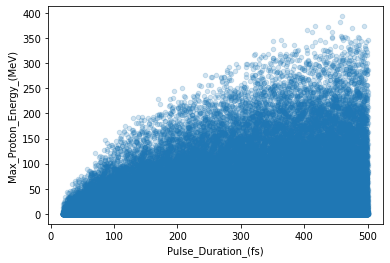

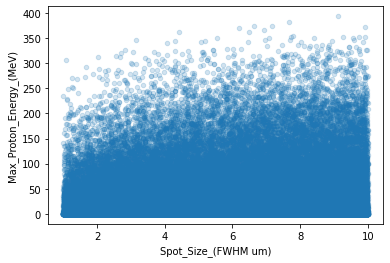

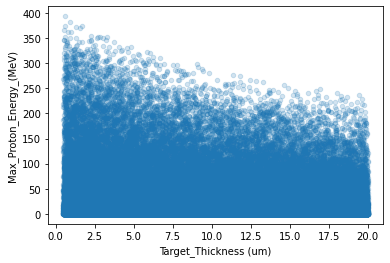

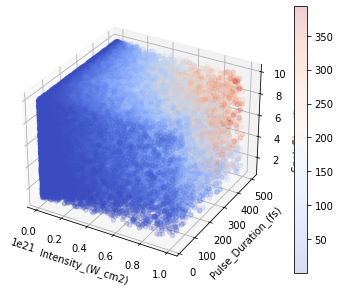

In [ ]:
physics.plot(
    x="Intensity_(W_cm2)",
    y="Max_Proton_Energy_(MeV)",
    kind="scatter",
    alpha=0.2
)
physics.plot(
    x="Pulse_Duration_(fs)",
    y="Max_Proton_Energy_(MeV)",
    kind="scatter",
    alpha=0.2
)
physics.plot(
    x="Spot_Size_(FWHM um)",
    y="Max_Proton_Energy_(MeV)",
    kind="scatter",
    alpha=0.2
)
physics.plot(
    x="Target_Thickness (um)",
    y="Max_Proton_Energy_(MeV)",
    kind="scatter",
    alpha=0.2
)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
p = ax.scatter(physics["Intensity_(W_cm2)"], physics["Pulse_Duration_(fs)"], physics["Spot_Size_(FWHM um)"], c=physics["Max_Proton_Energy_(MeV)"], cmap=cm.coolwarm, alpha=0.2)
fig.colorbar(p, ax=ax)
ax.set_xlabel("Intensity_(W_cm2)")
ax.set_ylabel("Pulse_Duration_(fs)")
ax.set_zlabel("Spot_Size_(FWHM um)")
fig.tight_layout()
fig.show()


# Defining a Model
*We are going to begin with using a DNN with 2 hidden layers and 16 neurons per layer. We are goiung to need to find w and b from Yhat = w times x+b where w is the weight of each function x and b is the bias on the neuron.*

*Begin with trying to predict Max_proton_energy from the other vars.*

Create the model structure

In [ ]:
torch.set_default_dtype(torch.float64)
class RegressionNetwork(nn.Module):
  def __init__(self):
    super(RegressionNetwork, self).__init__()

    self.linear1 = torch.nn.Linear(4, 64)
    self.activation1 = torch.nn.ReLU()
    self.linear2 = torch.nn.Linear(64, 8)
    self.activation2 = torch.nn.ReLU()
    self.linear3 = torch.nn.Linear(8, 1)

  def forward(self, x):
    x = self.linear1(x)
    x = self.activation1(x)
    x = self.linear2(x)
    x = self.activation2(x)
    x = self.linear3(x)
    return x

Define our custom dataset

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, data, transform=None, target_transform=None):
    self.inputs = data[list(set(physics.columns) - {'Max_Proton_Energy_(MeV)'})].values
    self.labels = data['Max_Proton_Energy_(MeV)'].values
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    ret_input = self.inputs[idx]
    ret_label = self.labels[idx]

    if self.transform:
        ret_input = self.transform(ret_input)
    if self.target_transform:
        ret_label = self.target_transform(ret_label)
    return ret_input, ret_label


Partition our data for training and testing. (80-20)

In [ ]:
train_data = CustomDataset(physics_train_norm)
test_data = CustomDataset(physics_test_norm)

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=4)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=4)

print('Training set has {} instances'.format(len(train_dataloader)))
print('Test set has {} instances'.format(len(test_dataloader)))

feature, label = next(iter(train_dataloader))

print(f"Feature batch shape: {feature} - {label}")


Training set has 20000 instances
Test set has 5000 instances
Feature batch shape: tensor([[-0.8204, -1.3208, -0.5408, -1.2484],
        [-1.0197,  0.1678,  1.0711,  1.6176],
        [ 0.3629, -1.1150, -0.3865,  1.5904],
        [ 1.4164, -0.4900,  2.4507,  1.0777]]) - tensor([-0.5899,  2.8364, -0.2229,  1.7054])


Define our training loop

In [ ]:
model = RegressionNetwork()

print("Model Shape: ")
for parameter in model.parameters():
  print(parameter.dtype)
  print(parameter.shape)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_function = torch.nn.MSELoss()

def train_one_epoch(epoch_index, tb_writer):
  running_loss = 0.
  last_loss = 0.

  for i, data in enumerate(train_dataloader):

    inputs, label = data
    optimizer.zero_grad()

    # Prediction
    outputs = torch.squeeze(model(inputs), 1)

    # Get the loss and the gradient
    loss = loss_function(outputs, label)
    loss.backward()

    # Adjust the weights
    optimizer.step()

    running_loss += loss.item()
    if i % 1000 == 999:
        last_loss = running_loss / 1000 # loss per batch
        print('  batch {} loss: {}'.format(i + 1, last_loss))
        tb_x = epoch_index * len(train_dataloader) + i + 1
        tb_writer.add_scalar('Loss/train', last_loss, tb_x)
        running_loss = 0.

  return last_loss

Model Shape: 
torch.float64
torch.Size([64, 4])
torch.float64
torch.Size([64])
torch.float64
torch.Size([8, 64])
torch.float64
torch.Size([8])
torch.float64
torch.Size([1, 8])
torch.float64
torch.Size([1])


per epoch activity loop

In [ ]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 35
epoch_train_loss = []
epoch_test_loss = []

best_tloss = 1_000_000

for epoch in range(EPOCHS):
  print('EPOCH {}:'.format(epoch_number + 1))

  model.train(True)
  avg_loss = train_one_epoch(epoch_number, writer)

  model.train(False)
  running_vloss = 0.0

  # Test how well its trained
  for i, tdata in enumerate(test_dataloader):
    tinputs, tlabels = tdata

    toutputs = torch.squeeze(model(tinputs), 1)
    tloss = loss_function(toutputs, tlabels)
    running_vloss += tloss

  avg_tloss = running_vloss / (i + 1)
  print('LOSS train {} testing {}'.format(avg_loss, avg_tloss))
  epoch_train_loss.append(avg_loss)
  epoch_test_loss.append(avg_tloss.detach().numpy())

  # Log the running loss averaged per batch
  # for both training and validation
  writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_tloss },
                    epoch_number + 1)
  writer.flush()

  # Track best performance, and save the model's state
  if avg_tloss < best_tloss:
      best_vloss = avg_tloss
      model_path = '/content/drive/MyDrive/Colab_Notebooks/models/model_{}_{}'.format(timestamp, epoch_number)
      torch.save(model.state_dict(), model_path)

  epoch_number += 1


EPOCH 1:
  batch 1000 loss: 0.11561756745014194
  batch 2000 loss: 0.029809961234504634
  batch 3000 loss: 0.02214138304706248
  batch 4000 loss: 0.017726210441352915
  batch 5000 loss: 0.012220611471519212
  batch 6000 loss: 0.010425031631971789
  batch 7000 loss: 0.008665435078476514
  batch 8000 loss: 0.008282852997870844
  batch 9000 loss: 0.008292604166152934
  batch 10000 loss: 0.008233851702621404
  batch 11000 loss: 0.006282933002947284
  batch 12000 loss: 0.005513109389020064
  batch 13000 loss: 0.005988765481522259
  batch 14000 loss: 0.005281205647116879
  batch 15000 loss: 0.004990770789839597
  batch 16000 loss: 0.004841603714064481
  batch 17000 loss: 0.004582793999220323
  batch 18000 loss: 0.0038742136078044865
  batch 19000 loss: 0.003962613832049234
  batch 20000 loss: 0.004570120506598169
LOSS train 0.004570120506598169 testing 0.0034572213550097936
EPOCH 2:
  batch 1000 loss: 0.003885159089443943
  batch 2000 loss: 0.004118594309309459
  batch 3000 loss: 0.004057761

Plot error over time

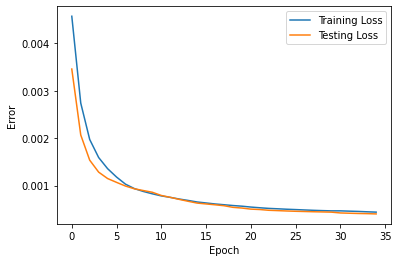

In [ ]:
plt.plot(epoch_train_loss, label='Training Loss')
plt.plot(epoch_test_loss, label='Testing Loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show()

Plug in our own data and see how accurate the guess seems.

In [ ]:
def denormalize(x):
  final_value = ( x * physics["Max_Proton_Energy_(MeV)"].std()) + physics["Max_Proton_Energy_(MeV)"].mean()
  return final_value

In [ ]:
TEMP_DATALOADER = torch.utils.data.DataLoader(test_data, batch_size=1)
feature, label = next(iter(TEMP_DATALOADER))
print("FEATURE LABEL: ", feature, label)

model.eval()

with torch.no_grad():
  pred = model(feature)

print(denormalize(label.detach().cpu().numpy()))
print(denormalize(pred.detach().cpu().numpy()))

FEATURE LABEL:  tensor([[ 1.5469e+00,  1.3980e+00, -5.2646e-01, -2.2209e-04]]) tensor([-0.4621])
[7.39108097]
[[7.7903526]]


# Test our developed Model
*Give our developed model novel information that it was NOT trained on.*

Define & normalise our inputs

In [ ]:
# Intensity_(W_cm2) 	Max_Proton_Energy_(MeV) 	Pulse_Duration_(fs) 	Spot_Size_(FWHM um) 	Target_Thickness (um)
inputs = {
    "Intensity_(W_cm2)": [4.430375e+19],
    "Max_Proton_Energy_(MeV)": [26.342629],
    "Pulse_Duration_(fs)": [276.923395],
    "Spot_Size_(FWHM um)": [7.890441],
    "Target_Thickness (um)": [4.746512]
}
predData = pd.DataFrame(inputs)
print(predData.info())

for column in predData:
  predData[column] = (predData[column] - physics[column].mean())/physics[column].std()

predDataSet = CustomDataset(predData)
predDataLoader = torch.utils.data.DataLoader(predDataSet)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Intensity_(W_cm2)        1 non-null      float64
 1   Max_Proton_Energy_(MeV)  1 non-null      float64
 2   Pulse_Duration_(fs)      1 non-null      float64
 3   Spot_Size_(FWHM um)      1 non-null      float64
 4   Target_Thickness (um)    1 non-null      float64
dtypes: float64(5)
memory usage: 168.0 bytes
None


Evaluate input

In [ ]:
feature, label = next(iter(predDataLoader))
print("FEATURE LABEL: ", feature, label)

model.eval()

with torch.no_grad():
  pred = model(feature)

print(denormalize(pred.detach().cpu().numpy()))

FEATURE LABEL:  tensor([[-0.9699,  0.9243, -0.4419,  0.1142]]) tensor([-0.0862])
[[26.44961867]]
